In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import scipy.integrate
import sklearn.discriminant_analysis
import itertools
%matplotlib inline

Utilizando los datos de Default construya una curva de precision-recall con los resultados del modelo regresión logística 
(http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html). 
Escriba su propia función. No utilice la de sklearn.

(0, 1)

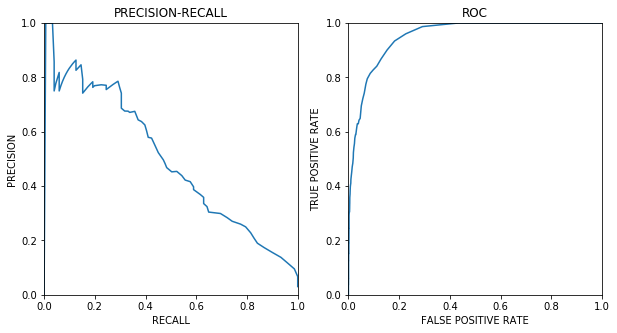

In [2]:
#Load data and define X, Y
data = pd.read_csv('Default.csv')
Y = data['default']
X = data[['balance']]
# Initialize fitting method, fit and predict
f = sklearn.linear_model.LogisticRegression()

# Split in train and test
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.5)

#  Fit with train
f.fit(X_train, Y_train)

# Predict with test
predict = f.predict(X_test)

# This is the probability for Default='Yes'
proba_yes = f.predict_proba(X_test)[:,1]

# loop over n_p different values for the threshold probabiity
n_p = 100
error_rate = np.zeros(n_p)
precision = np.zeros(n_p)
recall = np.zeros(n_p)
tp_rate = np.zeros(n_p)
fp_rate = np.zeros(n_p)
threshold = np.linspace(0,0.99, n_p)

for i in range(n_p):
    ii = proba_yes>threshold[i]
    predict[ii] = 'Yes'
    predict[~ii] = 'No'
    true_positive = (Y_test == 'Yes') & (predict == 'Yes') 
    false_positive = (Y_test == 'No') & (predict == 'Yes')
    false_negative = (Y_test == 'Yes') & (predict == 'No')
    true_negative = (Y_test == 'No') & (predict == 'No')
    n_tp = np.count_nonzero(true_positive)
    n_fp= np.count_nonzero(false_positive)
    n_fn = np.count_nonzero(false_negative)
    n_tn = np.count_nonzero(true_negative)
    if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
    if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn); tp_rate[i] = recall[i]  
    if((n_fp+n_tn)>0): fp_rate[i] = n_fp/(n_fp+n_tn)

        
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(recall, precision)
plt.xlabel('RECALL')
plt.ylabel('PRECISION')
plt.title('PRECISION-RECALL')
plt.xlim([0,1])
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(fp_rate, tp_rate)
plt.xlabel('FALSE POSITIVE RATE')
plt.ylabel('TRUE POSITIVE RATE')
plt.title('ROC')
plt.xlim([0,1])
plt.ylim([0,1])


b) 
Utilizando el siguiente dataset

https://vincentarelbundock.github.io/Rdatasets/doc/MASS/Boston.html 
https://vincentarelbundock.github.io/Rdatasets/csv/MASS/Boston.csv

encuentre los mejores predictores para saber si un suburbio tiene una rata de crimen mayor o menor a la media. 
Utilice LDA y regresion logistica junto a curvas ROC y Precision-Recall para justificar su respuesta.

In [3]:
def summary_fit(X, Y, f_method, plot=True):
    # Split in train and test
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.4)

    #  Fit with train
    f_method.fit(X_train, Y_train)

    # Predict with test
    predict = f_method.predict(X_test)

    # This is the probability for the '+' class
    proba_yes = f_method.predict_proba(X_test)[:,1]

    # loop over n_p different values for the threshold probabiity
    n_p = 100
    error_rate = np.zeros(n_p)
    precision = np.zeros(n_p)
    recall = np.zeros(n_p)
    tp_rate = np.zeros(n_p)
    fp_rate = np.zeros(n_p)
    threshold = np.linspace(0,0.99, n_p)

    for i in range(n_p):
        ii = proba_yes>threshold[i]
        predict[ii] = 'Yes'
        predict[~ii] = 'No'
        true_positive = (Y_test == 'Yes') & (predict == 'Yes') 
        false_positive = (Y_test == 'No') & (predict == 'Yes')
        false_negative = (Y_test == 'Yes') & (predict == 'No')
        true_negative = (Y_test == 'No') & (predict == 'No')
        n_tp = np.count_nonzero(true_positive)
        n_fp= np.count_nonzero(false_positive)
        n_fn = np.count_nonzero(false_negative)
        n_tn = np.count_nonzero(true_negative)
        if((n_tp+n_fp)>0): precision[i] = n_tp/(n_tp + n_fp)
        if((n_tp+n_fn)>0): recall[i] = n_tp/(n_tp + n_fn); tp_rate[i] = recall[i]  
        if((n_fp+n_tn)>0): fp_rate[i] = n_fp/(n_fp+n_tn)

    # compute the area under each curve
    ii = np.argsort(recall)
    pr_area = scipy.integrate.trapz(precision[ii], recall[ii])
    
    ii = np.argsort(fp_rate)
    roc_area = scipy.integrate.trapz(tp_rate[ii], fp_rate[ii])
            
    # compute F1
    F1 = np.max(2.0*precision*recall/(precision+recall+1E-12))
    if plot:
        l = 'Predictors:'
        for k in X.keys(): 
            l=l+' '+k
        
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.plot(recall, precision)
        plt.xlabel('RECALL')
        plt.ylabel('PRECISION')
        plt.title('PRECISION-RECALL, AREA={:.2f}'.format(pr_area))
        plt.xlim([0,1])
        plt.ylim([0,1])

        plt.subplot(1,2,2)
        plt.plot(fp_rate, tp_rate, label=l)
        plt.xlabel('FALSE POSITIVE RATE')
        plt.ylabel('TRUE POSITIVE RATE')
        plt.title('ROC, AREA={:.2f}'.format(roc_area))
        plt.xlim([0,1])
        plt.ylim([0,1])
        plt.legend()
    return {'pr_area':pr_area, 'roc_area':roc_area, 'F1':F1}

In [4]:
def find_best_predictors(X, Y, all_predictors, f_method):
    best = {'pr_area':0.0, 'roc_area':0.0, 'F1':0.0, 'predictors':''}

    # loop over all possible number of predictors
    for n_predictors in range(1,len(all_predictors)+1):
    
        # get all combinations of predictors of lenght=n_predictors
        combinations = itertools.combinations(all_predictors, n_predictors)
        for c in combinations:
            predictors = list(c)
            X_in = X[predictors]

            # if n_predictors=1, try it
            if(n_predictors==1): 
                print('Trying these predictors', predictors)
                areas = summary_fit(X_in, Y, f, plot=False)
            else:
                intersection = list(set(best['predictors']) & set(predictors))
                # only try the new predictors if they include the best['predictors']
                if len(intersection)==len(best['predictors']):
                    print('Trying these predictors', predictors)
                    areas = summary_fit(X_in, Y, f, plot=False)
                    
            # update the best values if needed. The best model increases, the ROC area and the Prec-Recall area and F1.
            if areas['pr_area']>best['pr_area'] and areas['roc_area']>best['roc_area'] and areas['F1'] > best['F1']:
                best['pr_area'] = areas['pr_area']
                best['roc_area'] = areas['roc_area']
                best['F1'] = areas['F1']
                best['predictors'] = predictors
                print('\t\t UPDATED BEST RESULTS: {}'.format(best))
    return best

In [5]:
# Read the data and initialize the binary data to predict
data = pd.read_csv('Boston.csv')

crimebinary = np.repeat('Yes', len(data))
ii = np.array(data['crim']>np.median(data['crim']))
crimebinary[ii] = 'Yes'
crimebinary[~ii] = 'No'
data['CRIME_BINARY'] = crimebinary

# select the full set of predictors to be used
all_predictors = ['zn','indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'black', 'lstat', 'medv']

# define X and Y
X = data[all_predictors]
Y = data['CRIME_BINARY']

In [6]:
# Find the best for Logistic Regression
f = sklearn.linear_model.LogisticRegression()
best = find_best_predictors(X, Y, all_predictors, f)
print(' ')
print('The best {}'.format(best))
print(' ')

Trying these predictors ['zn']
		 UPDATED BEST RESULTS: {'pr_area': 0.34877684539894754, 'roc_area': 0.68458676067371715, 'F1': 0.78723404255271412, 'predictors': ['zn']}
Trying these predictors ['indus']
		 UPDATED BEST RESULTS: {'pr_area': 0.77373241752437139, 'roc_area': 0.85369290573372203, 'F1': 0.80446927374253174, 'predictors': ['indus']}
Trying these predictors ['chas']
Trying these predictors ['nox']
		 UPDATED BEST RESULTS: {'pr_area': 0.90581275770762792, 'roc_area': 0.91752577319587636, 'F1': 0.85333333333284278, 'predictors': ['nox']}
Trying these predictors ['rm']
Trying these predictors ['age']
Trying these predictors ['dis']
Trying these predictors ['rad']
Trying these predictors ['tax']
Trying these predictors ['ptratio']
Trying these predictors ['black']
Trying these predictors ['lstat']
Trying these predictors ['medv']
Trying these predictors ['zn', 'nox']
Trying these predictors ['indus', 'nox']
Trying these predictors ['chas', 'nox']
		 UPDATED BEST RESULTS: {'pr_a

In [7]:
# Find the best with Linear Discriminant Analysis
f = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
best = find_best_predictors(X, Y, all_predictors, f)
print(' ')
print('The best {}'.format(best))
print(' ')

Trying these predictors ['zn']
		 UPDATED BEST RESULTS: {'pr_area': 0.36612281665425828, 'roc_area': 0.71794493608652898, 'F1': 0.80144404332081665, 'predictors': ['zn']}
Trying these predictors ['indus']
		 UPDATED BEST RESULTS: {'pr_area': 0.73290889878295007, 'roc_area': 0.86216268685692099, 'F1': 0.80225988700515949, 'predictors': ['indus']}
Trying these predictors ['chas']
Trying these predictors ['nox']
		 UPDATED BEST RESULTS: {'pr_area': 0.87673861665530206, 'roc_area': 0.93972044263249854, 'F1': 0.87619047618997647, 'predictors': ['nox']}
Trying these predictors ['rm']
Trying these predictors ['age']
Trying these predictors ['dis']
Trying these predictors ['rad']
Trying these predictors ['tax']
Trying these predictors ['ptratio']
Trying these predictors ['black']
Trying these predictors ['lstat']
Trying these predictors ['medv']
Trying these predictors ['zn', 'nox']
Trying these predictors ['indus', 'nox']
Trying these predictors ['chas', 'nox']
Trying these predictors ['nox',

Despues de 5 intentos con logistic regression tengo 5 resultados diferentes

```
The best {'pr_area': 0.95927442200708224, 'roc_area': 0.95343137254901966, 'F1': 0.90607734806580087, 
'predictors': ['zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'tax', 'ptratio']}
```
```
The best {'pr_area': 0.93341850837668949, 'roc_area': 0.95667550839964632, 'F1': 0.90647482014338687, 
'predictors': ['zn', 'chas', 'nox', 'tax', 'medv']}
```

```
The best {'pr_area': 0.91882803724052686, 'roc_area': 0.93843537414965983, 'F1': 0.88235294117597096, 
'predictors': ['zn', 'nox', 'ptratio', 'black']}
```

```
The best {'pr_area': 0.94901269335444871, 'roc_area': 0.95237864077669909, 'F1': 0.87850467289669842, 
'predictors': ['zn', 'chas', 'nox', 'age', 'dis', 'tax', 'lstat']}
```

```
The best {'pr_area': 0.95658316625643014, 'roc_area': 0.9477582846003898, 'F1': 0.89497716894927182, 
'predictors': ['chas', 'nox', 'age', 'tax', 'lstat']}
```

El único predictor que se encuentran en todos los 5 intentos  es `nox`, se encuentran 4 veces `chas`, `tax`, `zn`

Despues de 5 intentos con  Linear Discriminant Analysis tengo 5 resultados diferentes

```
The best {'pr_area': 0.93705403867125503, 'roc_area': 0.95151426907396619, 'F1': 0.89592760180945774, 
          'predictors': ['indus', 'nox', 'dis']}
```

```
The best {'pr_area': 0.85648960827681753, 'roc_area': 0.95633145302470335, 'F1': 0.8927038626604481, 
    'predictors': ['chas', 'nox', 'age', 'dis', 'tax', 'lstat']}
```

```
The best {'pr_area': 0.92179711248156537, 'roc_area': 0.96482021379980565, 'F1': 0.90350877192932766, 
'predictors': ['zn', 'indus', 'chas', 'rm', 'age', 'dis', 'rad', 'tax', 'ptratio', 'lstat', 'medv']}
```

```
The best {'pr_area': 0.84667733614022478, 'roc_area': 0.95971655989128324, 'F1': 0.91866028708083991, 
'predictors': ['zn', 'nox']}

```

```
The best {'pr_area': 0.88329262131391273, 'roc_area': 0.96158334954289049, 'F1': 0.89177489177439506, 
'predictors': ['nox', 'dis']}
```

Ningún predictor se encuentra en todos los 5 intentos. `nox` y `dis` se encuentran 4 veces.